In [11]:
%matplotlib inline

import osmnx as ox
import numpy as np
# from hmmlearn.hmm import MultinomialHMM
import matplotlib.pyplot as plt

from math import cos, sin, asin, sqrt, radians

import geopandas as gpd
from shapely.geometry import Point, LineString

import networkx as nx
import geopandas as gpd

# LOAD DATA

In [30]:
import pandas as pd
# lat | lon,
# ...
fname='my_preprocess025.csv'
path='input/'
df = pd.read_csv(f'{path}{fname}')
df = df.loc[:10000,['y','x','ts','trip']]
df.head()

y           x          ts  trip
0  10.767700  106.667200  1524827103     4
1  10.768700  106.666680  1524827133     4
2  10.769720  106.666180  1524827163     4
3  10.765512  106.667780  1524819560     5
4  10.766058  106.667656  1524819570     5

## Drop trip if 2 coords i, i+1 has length too large 

In [31]:
def get_list_trace(df):
    '''
    Convert from dataframe to list traces

    input:
        dataframe has [x,y,trip] columns
    output:
        list traces
    '''
    df['result'] = df.set_index('trip').values.tolist()
    df = df.groupby('trip')['result'].apply(list)
    list_trace = df.values
    return list_trace
    
def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km * 1000

def drop_unvalid_trip(df, dis_thresh=50):
    '''
    dis_thresh: unit meters
    '''
    list_trace = get_list_trace(df[['x','y','trip']].copy())
    dropped_idxs = []
    for idx, trace in enumerate(list_trace):
        # calculate haversine distance between 2 points i & i+1
        trace_len = len(trace)
        for i, coords in enumerate(trace):
            if i==trace_len-1:
                break
            # p1 = (trace[i][1], trace[i][0])
            # p2 = (trace[i+1][1], trace[i+1][0])
            dis = haversine(trace[i][1], trace[i][0], trace[i+1][1], trace[i+1][0])
            if dis > dis_thresh:
                dropped_idxs.append(idx)
                break
    # drop 
    is_drop = df.trip.isin(dropped_idxs)
    df_dropped = df[~is_drop]
    return df_dropped

In [32]:
df = drop_unvalid_trip(df)
df

y           x          ts  trip
23     10.769633  106.666160  1524805210    15
24     10.769332  106.666260  1524805220    15
25     10.768826  106.666450  1524805240    15
26     10.768447  106.666595  1524805290    15
27     10.768350  106.666695  1524805361    15
...          ...         ...         ...   ...
9996   10.767850  106.671165  1524816942  5519
9997   10.767967  106.669170  1524823722  5520
9998   10.768167  106.668000  1524823742  5520
9999   10.767850  106.667170  1524823802  5520
10000  10.767833  106.671330  1524828382  5525

[6364 rows x 4 columns]

# TEST: Hidden Markov Models by Kuanbutts
http://kuanbutts.com/2020/08/25/simplified-map-matching/

## Get osm graph: vbd

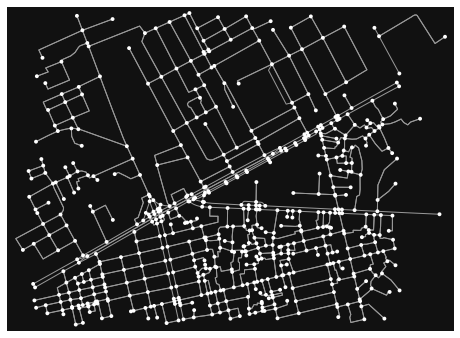

In [33]:
min_x = df['x'].min()
max_x = df['x'].max()

min_y = df['y'].min()
max_y = df['y'].max()
west, south, east, north = max_x, min_y, min_x, max_y
G1 = ox.graph_from_bbox(north, south, east, west,network_type='all_private', truncate_by_edge=True, retain_all=True)
fig, ax = ox.plot_graph(G1)


## Get osm graph: article

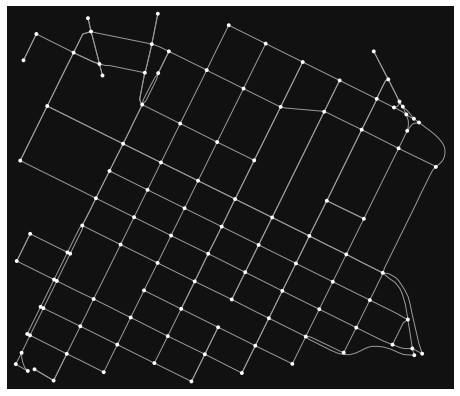

In [4]:
from shapely.geometry import Polygon

p = Polygon([
            [
              -122.27465629577637,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.7983230783235
            ]
          ])

west, south, east, north = p.bounds
G1 = ox.graph_from_bbox(north, south, east, west,network_type='drive')
fig, ax = ox.plot_graph(G1)

## Convert graph to GDF

In [34]:
rows = []
for node_from, node_to, edge in G1.edges(data=True):
    if "geometry" in edge.keys():
        geometry = edge["geometry"]
    else:
        f = G1.nodes[node_from]
        t = G1.nodes[node_to]
        geometry = LineString([[f["x"], f["y"]], [t["x"], t["y"]]])
    base = {
        "from": node_from,
        "to": node_to,
        "id": edge["osmid"],
        "length": edge["length"],  # meters
        "geometry": geometry,
    }
    rows.append(base)
gdf = gpd.GeoDataFrame(rows)

In [35]:
gdf.head()

from          to         id  length  \
0  366372448  5057828486   32586227  30.882   
1  366372448  5057828564   32586227  38.903   
2  366372448  5057828560  468380366  28.809   
3  366372448  5057828543  468380366  40.051   
4  366374108  5057828212   32586228  19.541   

                                            geometry  
0  LINESTRING (106.67178 10.76668, 106.67169 10.7...  
1  LINESTRING (106.67178 10.76668, 106.67184 10.7...  
2  LINESTRING (106.67178 10.76668, 106.67176 10.7...  
3  LINESTRING (106.67178 10.76668, 106.67180 10.7...  
4  LINESTRING (106.66511 10.76511, 106.66528 10.7...

## Init a observation trace: vbd

In [28]:
df[df.datetime ==-28936192]

vehicle           x          y  datetime  trip     heading
503    50LD10181  106.664910  10.766485 -28936192    84   61.236426
1287   50LD10265  106.671814  10.770242 -28936192   222  245.655745
1288   50LD10265  106.671776  10.770225 -28936192   222  230.755911
1289   50LD10265  106.671750  10.770204 -28936192   222  239.359039
1290   50LD10265  106.671610  10.770122 -28936192   222  239.563747
1958    51B16058  106.669500  10.772032 -28936192   348  149.605910
1959    51B16058  106.669640  10.771796 -28936192   348  152.271789
4245    51F47887  106.667366  10.766649 -28936192   795  165.251051
4564    51F51903  106.670135  10.769386 -28936192   864  239.634607
5125    51F58744  106.671770  10.766928 -28936192   983  350.902643
6649    51F94919  106.668236  10.767872 -28936192  1300   91.843544
6650    51F94919  106.669210  10.767841 -28936192  1300   88.163285
6651    51F94919  106.669620  10.767854 -28936192  1300   91.727578
6652    51F94919  106.670760  10.767820 -28936192  1300   89.356160
11105   63A00287  106.669334  10.767852 -28936192  2110   93.435501
11106   63A00287  106.670210  10.767800 -28936192  2110   93.435501

In [23]:
def get_trace(df, trip_id):
    trace = df[df.trip==trip_id][['x','y']]
    trace = trace.apply(lambda coord: list([coord.x, coord.y]), axis=1)
    trace = LineString(list(trace))
    
    return trace 

In [24]:
trace = get_trace(df, 348)
trace

AssertionError: 

## Init a observation trace: article

In [9]:
# trace = LineString([[-122.26694762706754,37.79925985116652],[-122.26666867732999,37.79970068133491],[-122.2660920023918,37.800605646561564],[-122.26770132780074,37.80126899810456],[-122.26859986782071,37.80141311202907],[-122.26758331060408,37.80292417198254],[-122.26653456687926,37.804909907830265],[-122.26547777652739,37.806312818153785],[-122.26666331291199,37.80684261119228],[-122.26750552654266,37.80545242616099],[-122.26820826530457,37.80428685451822],[-122.27041840553284,37.80534222744762],[-122.27078318595886,37.80484209275872],[-122.27197408676149,37.8028076116559],[-122.27447390556335,37.80395201417224]])
trace = LineString([[-122.27041840553284,37.80534222744762],[-122.27078318595886,37.80484209275872],[-122.27197408676149,37.8028076116559],[-122.27447390556335,37.80395201417224]])

## Plot

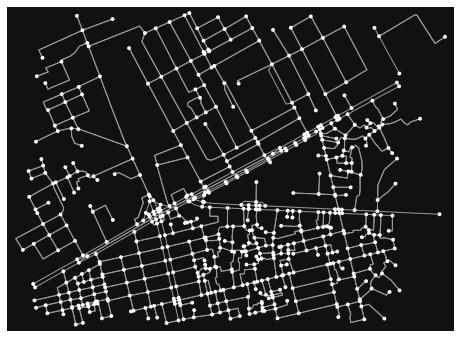

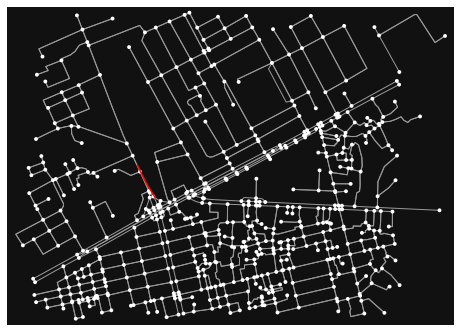

<Figure size 432x288 with 0 Axes>

In [455]:
fig, ax = ox.plot_graph(G1)
gpd.GeoSeries([trace]).plot(ax=ax, color='red')
fig

## Helper methods

In [36]:
def get_edges(gdf, x, y, t=20):
    p = Point(x, y)
    
    near_edges = []
    for gdf_ix, row in gdf.iterrows():
        l = row["geometry"]
        p2 = l.interpolate(l.project(p))
        d = haversine(y, x, p2.y, p2.x)
        if d < t:
            near_edges.append({
                "id": gdf_ix,
                "distance": d,
                "from_node": row["from"],
                "to_node": row["to"],
                "point_proj": p2
            })
    return near_edges

## HMM

In [37]:
class StateNode():
    def __init__(self, layer, trace_id, trace_node, edge_id, point_proj, distance, from_node, to_node, terminal=None):
        self.layer = layer
        self.trace_id = trace_id
        self.trace_node = trace_node
        self.edge_id = edge_id
        self.point_proj = point_proj
        self.distance = distance
        self.from_node = from_node
        self.to_node = to_node
        self.terminal = terminal
    def print_node(self):
        print('trace id:', self.trace_id)
        print('trace node:', self.trace_node)
        print('distance:', self.distance)
        print('point_proj:', self.point_proj)
        print('from_node:', self.from_node)
        print('to_node:', self.to_node)
    def __str__(self):
            return str(self.layer)

### Calculate probability


In [38]:
import math 
SIGMA_Z = 5
BETA = 13

def cal_emission_prob(distance):
    p_zt_ri = 1 / ( math.sqrt(2 * math.pi) * SIGMA_Z)
    p_zt_ri = p_zt_ri * math.exp(-0.5 * (distance / SIGMA_Z)**2)
    return p_zt_ri
def cal_transition_prob(dt):
    p_ri_ri1 = 1 / BETA * math.exp(-dt / BETA)
    return p_ri_ri1

def get_edge_prob_likelihood(start_node, end_node, attributes):
    # base conditions for terminal nodes
    if start_node.terminal == "start" or end_node.terminal == "end":
	# don't worry about first placeholder node to first "real" state node
	# and same for final placeholder terminal node
        return 1

    # calculate emission prob (likelihood of point being on this line)
    emission_prob = cal_emission_prob(start_node.distance)
    # calculate transition weight (likelihood of going from one edge to the next)
    try:
        # get proj node
        start_proj_node = start_node.point_proj
        end_proj_node = end_node.point_proj
        # query nearest node
        start_nearest_node = ox.nearest_nodes(G1, start_proj_node.x, start_proj_node.y)
        end_proj_node = ox.nearest_nodes(G1, end_proj_node.x, end_proj_node.y)
        graph_path = nx.dijkstra_path(G1, start_nearest_node, end_proj_node, weight="length")
        lengths = []
        for eid_from, eid_to in zip(graph_path[:-1], graph_path[1:]):
            lengths.append(G1[eid_from][eid_to][0]["length"])
        distance = sum(lengths)
    except nx.NetworkXNoPath:
        # fallback for impossible paths
        print('no path')
        distance = 1_000_000
    # calculate transition prob
    start_coords = G1.nodes[start_node.to_node]
    end_coords = G1.nodes[end_node.from_node]
    great_circle_distance = haversine(start_node.trace_node.y, start_node.trace_node.x, end_node.trace_node.y,  end_node.trace_node.x)
    transition_prob = cal_transition_prob(abs(great_circle_distance - distance))
    print(emission_prob, transition_prob)
    return (emission_prob*transition_prob)

In [39]:
def get_edge_likelihood(start_node, end_node, attributes):
    # base conditions for terminal nodes
    if start_node.terminal == "start" or end_node.terminal == "end":
	# don't worry about first placeholder node to first "real" state node
	# and same for final placeholder terminal node
        return 1

    # calculate emission weight (likelihood of point being on this line)
    emission_weight = start_node.distance ** 2  # simplified to exponentially weight greater distances

    # calculate transition weight (likelihood of going from one edge to the next)
    try:
        graph_path = nx.dijkstra_path(G1, start_node.to_node, end_node.from_node, weight="length")
        lengths = []
        for eid_from, eid_to in zip(graph_path[:-1], graph_path[1:]):
            lengths.append(G1[eid_from][eid_to][0]["length"])
        distance = sum(lengths)
    except nx.NetworkXNoPath:
        # fallback for impossible paths
        print('no path')
        distance = 1_000_000
    
    transition_weight = distance ** 2  # simplified to exponentially weight greater distances
    
    # simplified example of combining the two factors
    return emission_weight + transition_weight

In [47]:
def run_hmm(G1, trace):
    gdf_network = graph_to_gdf(G1)
    # initialize state graph
    markov_chain = nx.DiGraph()
    # initialize a start state with no real trace/edge associated
    start_state_node = StateNode(0, None, None, None, None, None, None, None, "start")
    markov_chain.add_node(start_state_node)

    # initialize state layers to connect each
    last_state = [start_state_node]

    for trace_ix, xy in enumerate(trace.coords):
        current_state = []
        x, y = xy
        # Step 1: For each trace point get a list of edges
        edges = get_edges(gdf_network, x, y)
        # Step 2: Create adjacency list: each edge can tragnsition to every other edge
        for e in edges:
            next_state_node = StateNode(trace_ix+1,trace_ix, Point(xy), e["id"], e["point_proj"], e["distance"], e["from_node"], e["to_node"])
            # print(f'from {G1.nodes[e["from_node"]]["y"], G1.nodes[e["from_node"]]["x"]} to {G1.nodes[e["to_node"]]["y"], G1.nodes[e["to_node"]]["x"]}')
            markov_chain.add_node(next_state_node)
            current_state.append(next_state_node)
            
            for last_node in last_state:
                markov_chain.add_edge(last_node, next_state_node)
        
        # reset what last state is
        last_state = current_state
        
    # add last state node placeholder
    end_state_node = StateNode(len(list(trace.coords)) + 1, None, None, None, None, None, None, None, "end")
    markov_chain.add_node(end_state_node)
    for last_node in last_state:
        markov_chain.add_edge(last_node, end_state_node)

    calculated_path = None
    try:
        calculated_path = nx.dijkstra_path(markov_chain, start_state_node, end_state_node, weight=get_edge_prob_likelihood)
    except:
        print(f'khong co duong di: {start_state_node} to {end_state_node}')
        pass
        # print('Ko co duong di')
    return calculated_path


In [48]:
def get_path_edges(calculated_path, gdf_network, G=G1):
    path_edges = []

    calculated_path_trimmed = [c for c in calculated_path if c.edge_id is not None]

    for cp in calculated_path_trimmed:
        row = gdf_network.loc[cp.edge_id].copy()
        trace_sr = pd.Series(cp.trace_id,index=['trace_id'])
        row = row.append(trace_sr)
        
        if len(path_edges) == 0:
            path_edges.append(row)
            continue
        
        last_edge = path_edges[-1]
        if last_edge.to == row["from"]:
            path_edges.append(row)
            continue
        try:
            intermediate_path = nx.dijkstra_path(G, last_edge.to, row["from"], weight="length")
        except:
            # print('Ko co duong di')
            path_edges = None
            break
        else:
            for ip_id_from, ip_id_to in zip(intermediate_path[:-1], intermediate_path[1:]):
                mask_1 = gdf_network["from"] == ip_id_from
                mask_2 = gdf_network["to"] == ip_id_to
                ip_row = gdf_network[mask_1 & mask_2].head(1).squeeze()
                ip_row = ip_row.append(trace_sr)
                path_edges.append(ip_row)

    return path_edges

## Plot traces

In [23]:
trace

NameError: name 'trace' is not defined

In [24]:
trace = get_trace(df, 403)
calculated_path = run_hmm(G1, trace)
path_edges = get_path_edges(calculated_path, gdf)
if path_edges != None:
    trace_proj = get_project_trace(trace, path_edges)
trace_proj

NameError: name 'get_trace' is not defined

NameError: name 'trace_proj' is not defined

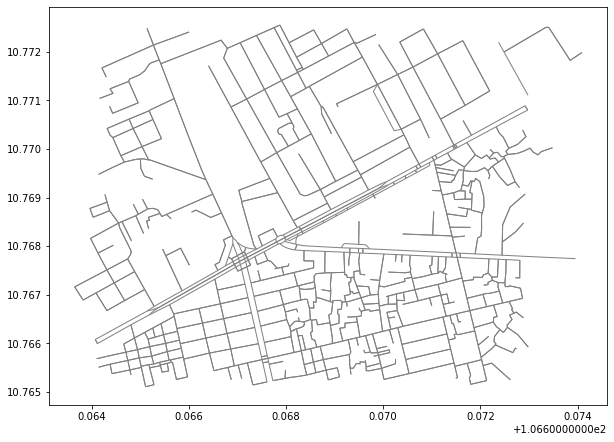

In [25]:
# plot the base map in grey
ax = gdf.plot(figsize=(10,10), lw=1, color="grey")
# raw trace in red
gpd.GeoSeries([trace_proj]).plot(ax=ax, color="green")
# raw trace in red
gpd.GeoSeries([trace]).plot(ax=ax, color="red")
# # map-matched trace in blue
# calculated_path = run_hmm(G1, trace)
# path_edges = get_path_edges(calculated_path, gdf)
# gpd.GeoSeries([row["geometry"] for row in path_edges]).plot(ax=ax, color="blue")

## EXTRACT PROJECTED COORDS

In [49]:
def get_project_trace(trace, path_edges):
    trace_ls = list(trace.coords)

    trace_visited = []
    trace_proj = []
    for e in path_edges:
        if e.trace_id not in trace_visited:
            line = e['geometry']
            point = trace_ls[e['trace_id']]
            point = Point(point[0], point[1])
            
            point_proj = line.interpolate(line.project(point))
            trace_proj.append(point_proj)
        else:
            # print(f'trace {e.trace_id} has been visited.')
            pass
        # mark trace as visited
        trace_visited.append(e.trace_id)
    return LineString(trace_proj)

# RUN WITH DATA

In [50]:
def graph_to_gdf(G):  
    rows = []
    for node_from, node_to, edge in G.edges(data=True):
        if "geometry" in edge.keys():
            geometry = edge["geometry"]
        else:
            f = G.nodes[node_from]
            t = G.nodes[node_to]
            geometry = LineString([[f["x"], f["y"]], [t["x"], t["y"]]])
        base = {
            "from": node_from,
            "to": node_to,
            "id": edge["osmid"],
            "length": edge["length"],  # meters
            "geometry": geometry,
        }
        rows.append(base)
    gdf = gpd.GeoDataFrame(rows)
    return gdf

In [51]:
gdf = graph_to_gdf(G1)
list_trace = get_list_trace(df[['x','y','trip']].copy())

ls_x = []
ls_y = []
trips = []
trips_raw = []
trip_counter = 0
for id, trace in enumerate(list_trace):
    if len(trace)==1:
        print(len(trace))
        continue
    else:
        print(len(trace))
    trace = LineString(trace)
    # run hmm
    calculated_path = run_hmm(G1, trace)
    if calculated_path!=None:
        path_edges = get_path_edges(calculated_path, gdf)
        if path_edges!=None:
            trace_proj = get_project_trace(trace, path_edges)
            
            # # PLOT
            # # raw trace in red
            # gpd.GeoSeries([trace_proj]).plot(ax=ax, color="blue")

            # convert to list
            ls_x = ls_x + list(trace_proj.coords.xy[0])
            ls_y = ls_y + list(trace_proj.coords.xy[1])
            trips = trips + [trip_counter]*len(list(trace_proj.coords.xy[0]))
            trips_raw = trips_raw  + [id]*len(list(trace.coords.xy[0]))
            # counter
            trip_counter = trip_counter + 1
# get df_proj
dict = {'x': ls_x, 'y': ls_y, 'trip': trips,'trip_raw': trips_raw}
df_proj = pd.DataFrame(dict)
df_proj

24
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02187577893584235 0.00512721112757998
0.02693906041771169 0.012699039886609751
0.02693906041771169 0.012699039886609751
0.007657038395860772 0.012699039886609751
0.007657038395860772 0.012699039886609751
0.007660002620306216 0.012699039886609751
0.007660002620306216 0.012699039886609751
0.007657038395860772 0.012699039886609751
0.007657038395860772 0.012699039886609751
0.02693906041771169 0.012699039886609751
0.02693906041771169 0.012699039886609751
0.007660002620306216 0.012699039886609751
0.007660002620306216 0.012699039886609751
0.000642081851345

# VISUALIZE

In [323]:
import folium
colors = [
    'green',
    'red',
    'orange',
    'yellow',
    'pink']

def create_map_obj():
    # Khởi tạo bản đồ mapobj
    f = folium.Figure(height=600)
    mapobj = folium.Map([10.778015126603638, 106.68162304214593], zoom_start=15, tiles='Cartodbpositron')
    mapobj.add_to(f)
    return mapobj

def add_point(map_obj, series, color):
    # Nạp x,y từ dataframe vào list coords
    coord =(series.y, series.x)
    # Hiển thị trên map_obj
    folium.CircleMarker(location=coord,
                        radius=2,
                        fill=True,
                        fill_opacity=1,
                        color=color,
                        weight=1).add_to(map_obj)
    return map_obj

def add_points(map_obj, df, color):
    # Nạp x,y từ dataframe vào list coords
    coords = list(zip(df.y, df.x))
    # Hiển thị trên map_obj
    for coord in coords:
        folium.CircleMarker(location=coord,
                            radius=2,
                            fill=True,
                            fill_opacity=0.25,
                            color=color,
                            weight=1).add_to(map_obj)
    return map_obj

def add_lines(map_obj, df, color):
    coords = list(zip(df.y, df.x))
    folium.PolyLine(coords, color=color, weight=3, opacity=1).add_to(map_obj)
    return map_obj

def show_trip(mapobj, trip_df, connect=0, color_key=1):
    """
    Describe: Show 1 trip \n
    connect = 0 -> show point only,      connect = 1 -> show line
    color_key: choose trip's color
    """
    # init colors
    colors = ['green','red','orange','yellow','pink']

    # coloring into mapobj
    add_points(mapobj, trip_df, colors[color_key % len(colors)])
    if connect == 1:
        add_lines(mapobj, trip_df, colors[color_key % len(colors)])


    return mapobj

In [ ]:
map_obj = create_map_obj()
map_obj = add_points(map_obj, df_proj, color=colors[1])
map_obj.save('output/matching.html')
map_obj

In [ ]:
map_obj = create_map_obj()
trips = df['trip'].unique()
for id in trips:
    map_obj = show_trip(map_obj, df[df.trip==id],connect=1)
map_obj


# SHAPEFILE SAVING

In [ ]:
df_copy = df_proj.copy()

geometry = [Point(xy) for xy in zip(df_copy.x, df_copy.y)]
gdf = gpd.GeoDataFrame(
    df_copy, geometry=gpd.points_from_xy(df_copy['x'], df_copy['y']))
gdf = gdf.drop(['x', 'y'], axis=1)
line_gdf = gdf.groupby(['trip'])['geometry'].apply(lambda x: LineString(x.tolist()))
line_gdf = gpd.GeoDataFrame(line_gdf, geometry='geometry')
line_gdf

geometry
trip                                                   
0     LINESTRING (106.66946 10.77209, 106.66987 10.7...
1     LINESTRING (106.67110 10.76952, 106.67119 10.7...
2     LINESTRING (106.67198 10.76585, 106.67193 10.7...
3     LINESTRING (106.67141 10.76787, 106.66958 10.7...
4     LINESTRING (106.66700 10.76808, 106.66689 10.7...
...                                                 ...
2238  LINESTRING (106.66539 10.76674, 106.66618 10.7...
2239  LINESTRING (106.67182 10.77028, 106.67145 10.7...
2240  LINESTRING (106.66804 10.76821, 106.66578 10.7...
2241  LINESTRING (106.66736 10.76779, 106.66785 10.7...
2242  LINESTRING (106.66667 10.76868, 106.66691 10.7...

[2243 rows x 1 columns]

In [41]:
line_gdf.to_file('output/shp/matching.shp')

# CONNECT PostgreSQL

In [45]:
# DROP ROWS INVALID
trips_proj = df_proj['trip_raw'].unique()
df_dropped = df[df['trip'].isin(trips_proj)]
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11840 entries, 0 to 11874
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   vehicle   11840 non-null  object 
 1   x         11840 non-null  float64
 2   y         11840 non-null  float64
 3   datetime  11840 non-null  int32  
 4   trip      11840 non-null  int64  
 5   heading   11840 non-null  float64
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 601.2+ KB


In [50]:
import psycopg2
# CONNECTING DB
conn = psycopg2.connect(
    host="localhost",
    database="vbd_mapmatching",
    user="postgres",
    password="12345678")

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Executing an MYSQL function using the execute() method
cursor.execute("select * from gps_trajectory")

# Fetch a single row using fetchone() method.
data = cursor.fetchone()
print("Connection established to: ",data)


Connection established to:  (None, '0101000020E610000026016A6AD9AA5A40111C9771538B2540', '0101000020E61000005659787CD8AA5A40F033EA1C4F8B2540', 0.0, None, 1118777344.0, '42.0', '', True, 'vbd_streetview')


In [51]:
# CLEAR TABLE
clear_table_query = f'''
delete from gps_trajectory
'''
cursor.execute(clear_table_query)
# INSERT ROWS
for i, row in df_proj.iterrows():
    p_proj = row[['x','y']].values
    p_raw = df.loc[i][['x','y']].values
    dtime = df.loc[i]['datetime']
    trip_id = row['trip']

    insert_data_query = f'''
    insert into gps_trajectory (gps_position, snap_position, datetime_taken, trip_guid) 
    values(ST_GeomFromText('POINT({p_raw[0]} {p_raw[1]})', 4326),
             ST_GeomFromText('POINT({p_proj[0]} {p_proj[1]})', 4326),
             '{dtime}',
             '{int(trip_id)}');
    '''
    # insert
    cursor.execute(insert_data_query)
# Commit your changes in the database
conn.commit()


In [52]:
#Closing the connection
conn.close()